This notebook gives an example of how one can analyze different runs in the same database. 
This is for instance relevant if multiple analysis with veiligheidsrendement are made for the same traject.

### Import necessary libraries

In [2]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
from collections import defaultdict
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.database_analytics import *
from postprocessing.database_access_functions import * 
from postprocessing.generate_output import *

sns.set(style="whitegrid")
colors = sns.color_palette("colorblind", 10)



### Get the runs that are in the database
First we get an overview of the runs in the database

In [3]:
database_path = Path(r'c:\VRM\traject10_voor_handreiking\10-3\database_10-3.sqlite')
# casename = 'new_discounting'
run_list = get_overview_of_runs(database_path)
run_list = [run for run in run_list if run['optimization_type_name']== 'VEILIGHEIDSRENDEMENT']
pd.DataFrame(run_list)
print(run_list)
run_list = run_list[0:4]

[{'id': 1, 'name': 'Basisberekening Veiligheidsrendement', 'discount_rate': 0.03, 'optimization_type': 1, 'optimization_type_name': 'VEILIGHEIDSRENDEMENT'}]


Now, we want to learn which section has the largest effect on the traject failure probability. We use the probability derived from the assessment to: 
* sort sections based on their failure probability
* and find the influence by disabling a section 1 by 1.

[{'id': 5, 'beta': 4.1367742903542135, 'time': 50, 'section_data': 1}, {'id': 12, 'beta': 3.680632336130546, 'time': 50, 'section_data': 2}, {'id': 19, 'beta': 4.312968267704265, 'time': 50, 'section_data': 3}, {'id': 26, 'beta': 3.5832434475436474, 'time': 50, 'section_data': 4}, {'id': 33, 'beta': 3.0879940517579074, 'time': 50, 'section_data': 5}, {'id': 40, 'beta': 3.606389309727772, 'time': 50, 'section_data': 6}, {'id': 47, 'beta': 3.808711513225074, 'time': 50, 'section_data': 7}, {'id': 54, 'beta': 3.615388962106304, 'time': 50, 'section_data': 8}, {'id': 61, 'beta': 3.6541339156756165, 'time': 50, 'section_data': 9}, {'id': 68, 'beta': 3.601771112864795, 'time': 50, 'section_data': 10}, {'id': 75, 'beta': 3.516140089461028, 'time': 50, 'section_data': 11}, {'id': 82, 'beta': 3.645198745696572, 'time': 50, 'section_data': 12}, {'id': 89, 'beta': 3.662844867600392, 'time': 50, 'section_data': 13}, {'id': 96, 'beta': 3.350873736316954, 'time': 50, 'section_data': 14}, {'id': 103,

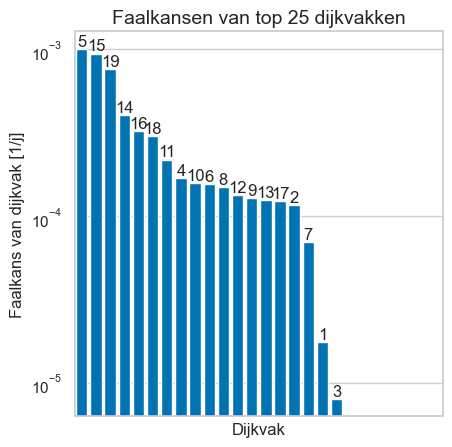

In [4]:
section_reliability_assessment_list = get_section_assessment_results(database_path)

# get beta for each section at 'time'
time = 25

section_reliability_assessment_list = [section for section in section_reliability_assessment_list if section['time'] == time]
print(section_reliability_assessment_list)
# Pf = norm.cdf(-beta)
# beta = -norm.ppf(Pf)
# add Pf to each key, based on beta. Pf = scipy.stats.norm.cdf(-beta)
for section_data in section_reliability_assessment_list:
    section_data['Pf'] = norm.cdf(-section_data['beta'])

# sort the list based on Pf and print sorted list in descending order
section_reliability_assessment_list_sorted_pf = sorted(section_reliability_assessment_list, key=lambda k: k['Pf'], reverse=True)
print(section_reliability_assessment_list_sorted_pf)

# print section ids and Pf
print()
for section in section_reliability_assessment_list_sorted_pf:
    print(f"section_id: {section['section_data']}, Pf: {section['Pf']}")


# write the results to a csv file with the steps, section id, beta and Pf
output_dir = database_path.parent
csv_failure_per_section = output_dir / 'failure_per_section.csv'
with open(csv_failure_per_section, 'w') as f:
    f.write('step, section id, beta, Pf\n')
    for i, section in enumerate(section_reliability_assessment_list_sorted_pf):
        f.write(f"{i+1}, {section['section_data']}, {section['beta']}, {section['Pf']}\n")

# create a bar plot of the Pf values (on the y axis) and the section ids (on the x axis)
# y-axis in log scale
fig, ax = plt.subplots()
top_x = 25
# make width dependent on number of sections, so that labels fit
fig.set_size_inches(0.25*len(section_reliability_assessment_list_sorted_pf), 5)
# add title
ax.set_title(f'Faalkansen van top {top_x} dijkvakken', fontsize=14)
ax.bar(np.arange(0, len(section_reliability_assessment_list_sorted_pf)), [section['Pf'] for section in section_reliability_assessment_list_sorted_pf], color=colors[0])
ax.set_yscale('log')
# add section_data above each bar
for i, section in enumerate(section_reliability_assessment_list_sorted_pf[0:top_x+1]):
    ax.text(i, section['Pf'], f"{section['section_data']}", ha='center', va='bottom')
ax.set_xlabel('Dijkvak', fontsize=12)
# hide x-ticks
ax.set_xticks([])
# show only first 25 sections, so set an xlim to the x-axis
ax.set_xlim(-0.5, top_x+.5)
ax.set_ylabel('Faalkans van dijkvak [1/j]', fontsize=12)
plt.show()


Get initial failure probability of the traject

In [ ]:
assessment_results = {mechanism: import_original_assessment(database_path, mechanism) 
                      for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER]}

initial_traject_prob_per_mechanism = calculate_traject_probability(assessment_results)
print(initial_traject_prob_per_mechanism)
# print the keys in initial_traject_prob_per_mechanism
print(initial_traject_prob_per_mechanism.keys())
# how many time steps are there in initial_traject_prob_per_mechanism?
n_time_steps = len(initial_traject_prob_per_mechanism[MechanismEnum.OVERFLOW])
print(n_time_steps)
# what are the time steps?
time_steps = initial_traject_prob_per_mechanism[MechanismEnum.OVERFLOW].keys()

# for each time step time, sum the probabilities of each mechanism in initial_traject_prob_per_mechanism, so you get one failure probability in each time step
# we don't know the amount of time steps in advance. Each of the three MechanismEnums has multiple failure probability values for n_time_steps
initial_traject_prob = {time: sum([initial_traject_prob_per_mechanism[mechanism][time] for mechanism in initial_traject_prob_per_mechanism]) for time in time_steps}
print(initial_traject_prob)


If we want to see the failure probability per stap we first need to load the original assessment for each mechanism, and then we can compute the reliability for each step during the optimization. 

In [ ]:
# get the section ids: section_data in section_reliability_assessment_list
section_ids = [section['section_data'] for section in section_reliability_assessment_list]
section_ids_temp = copy.deepcopy(section_ids) # create a copy to adjust the list in the loop
# get the number of sections
n_sections = len(section_ids)
# get the number of time steps for which a beta is calculated. This is the length of the beta list for the first mechanism in the first section
n_beta = len(assessment_results[MechanismEnum.OVERFLOW][section_ids[0]]['beta'])
print(f"n_sections: {n_sections}, n_beta: {n_beta}") 

t = 50

assessment_results_temp = copy.deepcopy(assessment_results)

section_in_step = [0]
beta_per_step = [initial_traject_prob[t]]

# loop over the different sections
for i in range(1, n_sections+1):
    min_traject_prob = 1
    min_section = 1000

    for section_id in section_ids_temp:
        assessment_results_temp_adj = copy.deepcopy(assessment_results_temp)
        # replace all beta values of section_id with a list containing n_beta times the value 8.0, and keep all values for the other sections the same
        for mechanism in assessment_results_temp.keys():
            # assessment_results_temp_adj = copy.deepcopy(assessment_results_temp)
            assessment_results_temp_adj[mechanism][section_id]['beta'] = [8.0]*n_beta

        # get the traject failure probability for the different mechanisms
        traject_failure_prob_temp_per_mechanism = calculate_traject_probability(assessment_results_temp_adj)
        # print("test", traject_failure_prob_temp_per_mechanism)
        
        traject_prob_temp = {time: sum([traject_failure_prob_temp_per_mechanism[mechanism][time] for mechanism in traject_failure_prob_temp_per_mechanism]) for time in time_steps}
        traject_prob_temp = traject_prob_temp[t]
        # print(traject_prob_temp)
        if traject_prob_temp <= min_traject_prob:
            min_traject_prob = traject_prob_temp
            min_section = section_id
    
    print(f"In step {i}, reinforcing section {min_section} leads to the largest probability reduction on traject level. Traject probability: {min_traject_prob}")
    # replace all beta values of min_section with a list containing n_beta times the value 8.0, and keep all values for the other sections the same
    for mechanism in assessment_results_temp.keys():
        assessment_results_temp[mechanism][min_section]['beta'] = [8.0]*n_beta
    
    # add min_section to section_in_step and min_traject_prob to beta_per_step
    section_in_step.append(min_section)
    beta_per_step.append(min_traject_prob)

    # remove min_section from section_ids
    section_ids_temp.remove(min_section)


In [ ]:
traject_probability_final = calculate_traject_probability(assessment_results_temp)
print(traject_probability_final)
traject_probability_final_final = {time: sum([traject_probability_final[mechanism][time] for mechanism in traject_probability_final]) for time in time_steps}
traject_probability_final_final = traject_probability_final_final[t]
print(traject_probability_final_final)

Create a plot of the results

In [ ]:
# create a bar plot of the Pf values (on the y axis) and the section ids (on the x axis)
# y-axis in log scale
fig, ax = plt.subplots()
# make width dependent on number of sections, so that labels fit
fig.set_size_inches(0.5*len(section_in_step), 5)
# add title
ax.set_title('Pf values of dike traject')
ax.bar(np.arange(0, len(section_in_step)), beta_per_step, color=colors[0])
ax.set_yscale('log')
# add section_data above each bar
for i in range(len(beta_per_step)):
    ax.text(i, beta_per_step[i], f"{section_in_step[i]}", ha='center', va='bottom')
ax.set_xlabel('strenthening step')
# hide x-ticks
# ax.set_xticks([])
ax.set_xlim(-0.5, len(section_in_step)+.5)
ax.set_ylabel('Pf')
plt.show()